## Privacy-Preserving Statistical Release
### Analysis of OSMI data 
#### Mental Health in Tech Survey

The purpose of this demo is to showcase the utility of the OpenDP SmartNoise library. The notebook will focus on statistical releases in the *trusted curator* setting.

Throughout his notebook, we make statistical queries to data with and without privacy-preserving mechanisms. As we compare query results side-by-side, we show that conclusions about the data are similar in both settings: without privacy-preserving mechanism, and with differential privacy mechanism. More precisely, the goals of this tutorial are:

- serve an audience with basic understanding of differential privacy;
- focus on reproducibility by using open data;
- showcase the easy usability of the SmartNoise package;
- focus on utility.


**Disclaimer:** The present notebook is not intended to serve as a study of mental illness in the tech industry, or make any conclusions about the scenario of mental illness in tech. We use the data set as a illustrative example of the SmartNoise tool in survey and human subject studies.

## 1 Data set

Mental health in tech survey data set is an open data set licensed under CC BY-SA 4.0. 

The data consists in 27 questions, aswered by 1,259 volunteers. For details on the data set, we refer the reader to the [Mental Health in Tech Survey](https://www.kaggle.com/osmi/mental-health-in-tech-survey)

The data used in the analysis was preprocessed. The original age, gender and country variables were mapped into categories for our analysis. We refer the reader to the [preprocessing notebook](data/Data%20set%20processing%20-%20Mental%20Health%20in%20Tech%20Survey.ipynb) for details on variable mappings.

The analysis will be focused on the following variables:
- **age**: age of the participant. Categorical variable with 5 categories: 21-30yo (0), 31-40yo (1), 41-50yo (2), 51-60yo (3), 60yo+ (4) 
- **gender**: gender declared by the participant, and in the survey the participants could input any string. We categorized answers as follows: Male/Man (1), Female/Woman(2), all other inputs (0).
- **country**: participant's country of residence. We categorized answers as follows: United States (1), United Kingdom (2), Canada (3), other countries (0).
- **remote_work**: binary value that indicates 
    if participant work remotely more than 50% of the time
- **family_history**: binary value that indicates if the 
    participant has a family history of mental illness 
- **treatment**: Binary value that 
    indicates if the participants has seeked 
    treatment for mental illness

## 2 Data Analysis and Exploration

In [1]:
##Import packages
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
sns.set(style = "whitegrid")
import polars as pl
import opendp.prelude as dp
dp.enable_features("contrib")

%matplotlib inline

In [2]:
path = 'survey_V2.csv'
df = pl.scan_csv(path)
vars =  ["age", "gender", "country", "remote_work", "family_history", "treatment"]
category_list = {"age":['21-30 years', '30-39 years', '40-49 years','50-59 years', '60+ years'],
                 "country":['Other','US', 'UK','CA' ],
                 "gender": ['Non-binary', 'Male', 'Female'], 
                 "remote_work": ['Does not work remotely', 'Works remotely' ], 
                 "family_history": ['Family history of MI','No family history'], 
                 "treatment": ['Not Diagnosed','Diagnosed']}

#this was borrowed from github
# https://github.com/pola-rs/polars/issues/4289
df = (
    df
    .with_columns([
        pl.col(pl.Int64).cast(pl.Int32).keep_name(),
        pl.col(pl.Float64).cast(pl.Float32).keep_name(),
    ])
)

df = (df.select(vars))

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_25806/2319299402.py:16: DeprecationWarning: `keep_name` is deprecated. It has been moved to `name.keep`.
  pl.col(pl.Int64).cast(pl.Int32).keep_name(),
/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_25806/2319299402.py:17: DeprecationWarning: `keep_name` is deprecated. It has been moved to `name.keep`.
  pl.col(pl.Float64).cast(pl.Float32).keep_name(),


### 2.1 Characteristics of survey participants

In the following analysis we explore the distribution of participants according to the following variables:
- age;
- gender;
- country;
- remote_work;
- family_history; 
- treatment.

We make simple histogram queries for each of the variables.

In [3]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=30,
    margins={
        ("age", ): dp.Margin(public_info="keys", max_partition_length=5),
        ("gender", ): dp.Margin(public_info="keys", max_partition_length=5),
        ("country", ): dp.Margin(public_info="keys", max_partition_length=5),
        ("remote_work", ): dp.Margin(public_info="keys", max_partition_length=5),
        ("family_history", ): dp.Margin(public_info="keys", max_partition_length=5),
        ("treatment", ): dp.Margin(public_info="keys", max_partition_length=5),
    },
)
print(context)

Context(
    accountant = Measurement(
        input_domain   = FrameDomain(age: i32, gender: i32, country: i32, remote_work: i32, family_history: i32, treatment: i32; margins=[{"remote_work"}, {"age"}, {"treatment"}, {"family_history"}, {"country"}, {"gender"}]),
        input_metric   = SymmetricDistance(),
        output_measure = MaxDivergence(f64)),
    d_in       = 1,
    d_mids     = [0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326, 0.033333333

## Build Your Queries 


In [4]:
all_frames = {}
for var in vars: 
    all_frames[var] = (context.query().group_by(var).agg(pl.len().dp.laplace()))
#note that if you try to look at all_frames, its a nonetype and you'll get an error! put in a mini FAQ section explaining why. onceframe?


Due to sequential composition, given $q_i$ queries, where each provide $\epsilon_i$-*differential privacy*, the sequence of queries provides $(\sum \epsilon_i)$-*differential privacy*. 

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_25806/1370318368.py:12: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  true = list(df.groupby(var).agg(pl.col(var).count().alias("len")).sort(var).collect()["len"])


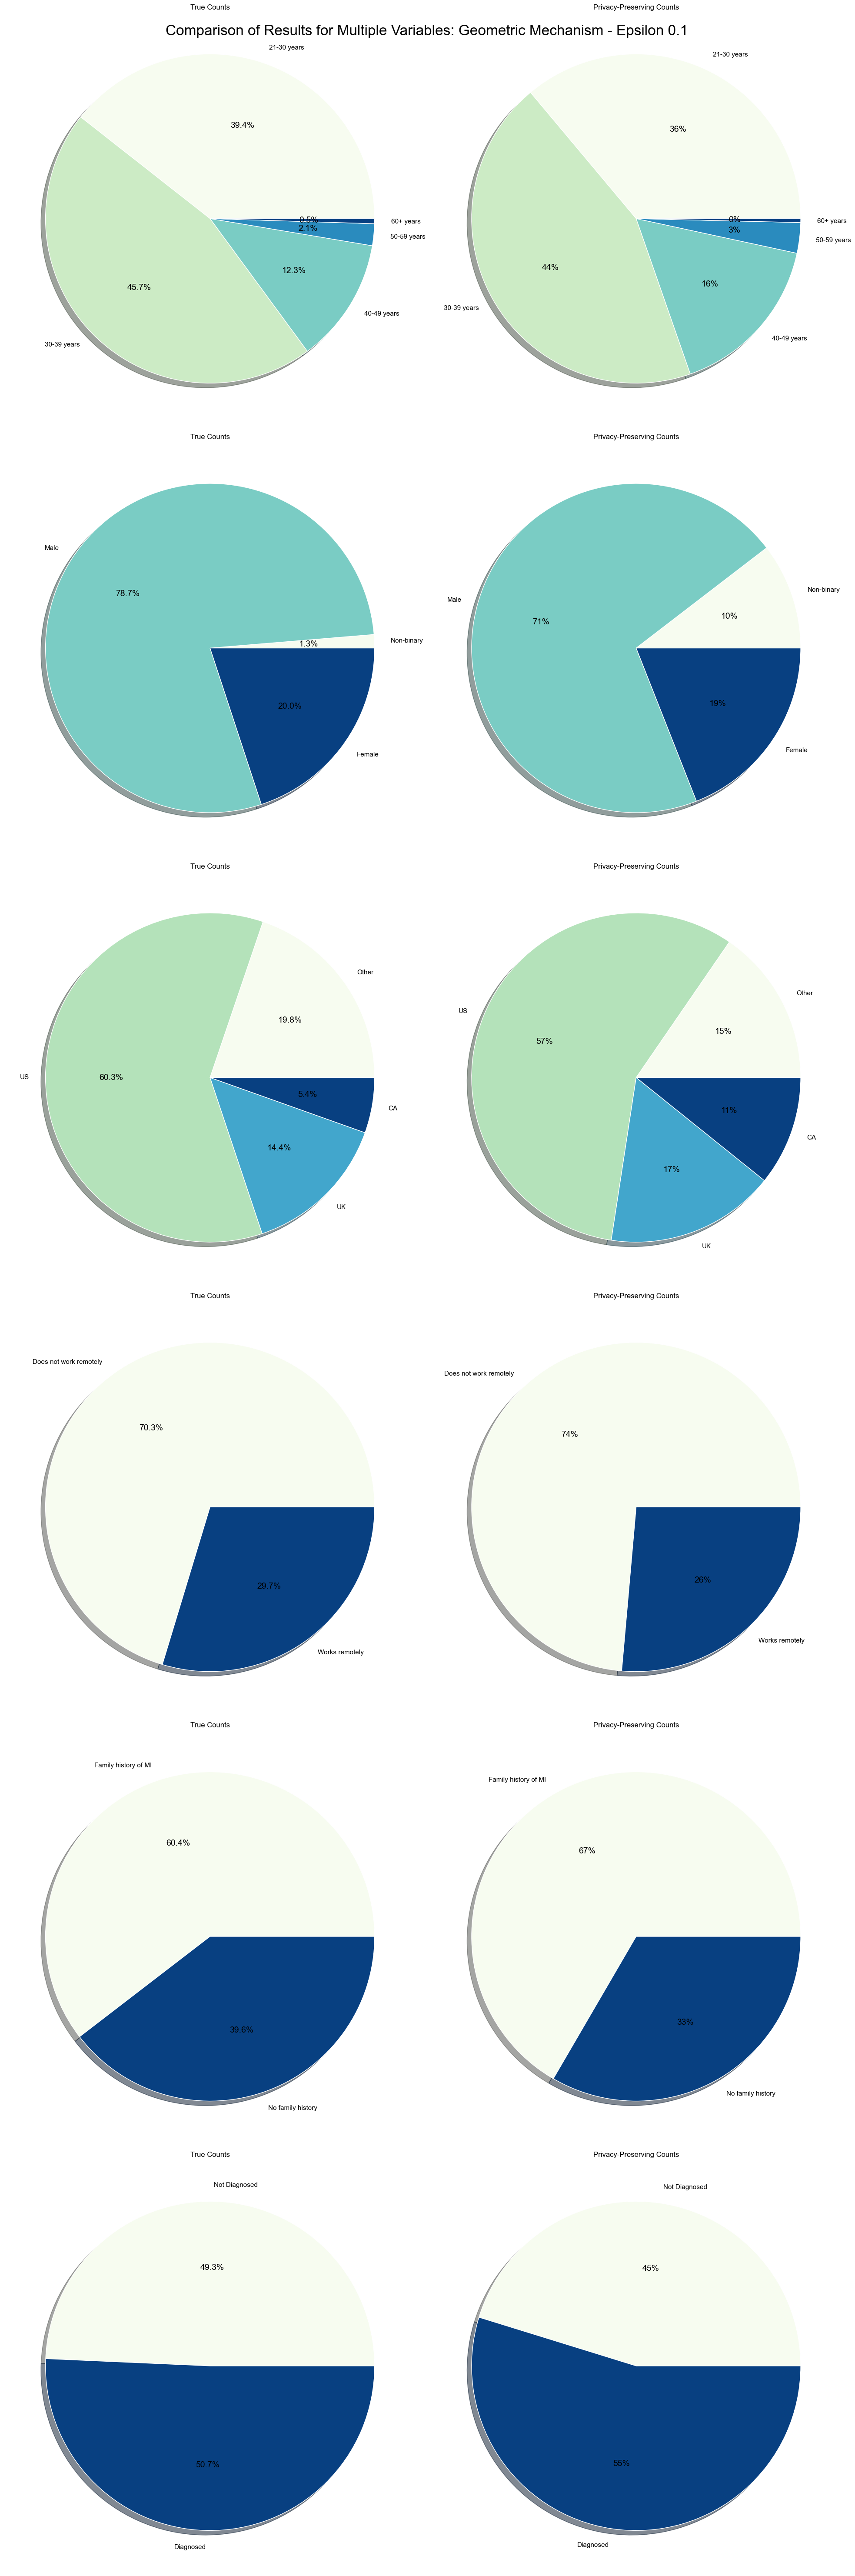

In [5]:
def pie_comparison(labels, true_counts, dp_counts, title, subtitle1, subtitle2, ax1, ax2):
    cmap = plt.get_cmap('GnBu')
    colors = [cmap(i) for i in np.linspace(0, 1, len(labels))]

    ax1.pie(true_counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors)
    ax1.set_title(subtitle1, color='#000000')

    ax2.pie(dp_counts, labels=labels, autopct='%.0f%%', shadow=True, colors=colors)
    ax2.set_title(subtitle2, color='#000000')
    
def make_pie_chart(var):
    true = list(df.groupby(var).agg(pl.col(var).count().alias("len")).sort(var).collect()["len"])
    dp = list(all_frames[var].release().collect().sort(var)['len'])
    epsilon_ = 0.1
    labels = category_list[var]
    title = f'Comparison of Results for Variable {var.capitalize()}: Geometric Mechanism - Epsilon '+str(epsilon_)
    subtitle1 = 'True Counts'
    subtitle2 = 'Privacy-Preserving Counts'
    return labels, true, dp, title 

# Set up the figure and grid
num_vars = len(vars)
fig = plt.figure(figsize=(20, 10 * num_vars))
the_grid = GridSpec(num_vars, 2)
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['font.size'] = 14

for i, var in enumerate(vars):
    labels, true_counts, dp_counts, title = make_pie_chart(var)
    subtitle1 = 'True Counts'
    subtitle2 = 'Privacy-Preserving Counts'

    ax1 = fig.add_subplot(the_grid[i, 0], aspect=1)
    ax2 = fig.add_subplot(the_grid[i, 1], aspect=1)

    pie_comparison(labels, true_counts, dp_counts, title, subtitle1, subtitle2, ax1, ax2)

fig.suptitle('Comparison of Results for Multiple Variables: Geometric Mechanism - Epsilon 0.1', fontsize=24)
plt.tight_layout()
plt.show()

### 2.2 Variable Interactions

For the queries in the following analysis, we will make histogram queries of disjoint subsets of the data.

Due to parallel composition, when queries are applied to disjoint subsets of the data, the privacy guarantee depends only on the maximum $\epsilon_i$, not the sum.

In [6]:
def prepare_dp_values(var, category):
    return (
        context.query().
        filter(pl.col(var) == category).
        group_by("treatment").
        agg(pl.len().dp.laplace())
        ).release().collect().sort("treatment")['len']

def get_actual_counts(var, category):
    return df.filter(pl.col(var) == category).groupby("treatment").agg(pl.col("treatment").count().alias("len")).sort("treatment").collect()["len"]

def make_dataframe(var, cat_list): 
    """
    Parameters: 
    var: The variable of interest. 
    cat_list: A list of category names for the variable of interest.
    """
    num = len(cat_list)
    
    #compute dp values by treatment
    dp_values = {c: prepare_dp_values(var, c) for c in range(num)}
    #compute actual values by treatment
    actual_values = {c: get_actual_counts(var,c) for c in range(num)}
    #combine dataframe
    data = {'Group': cat_list*2,
     'Process': num*['true value'] + num* ['privacy-preserving'],
     'Participants on treatment MI ':[actual_values[i][1] for i in range(num)] + [dp_values[i][1] for i in range(num)],
     'Participants not on treatment MI':[actual_values[i][0] for i in range(num)] + [dp_values[i][0] for i in range(num)],
     'Variable': var} 
    
    return pd.DataFrame(data=data)

In [7]:
age_df = make_dataframe("age", ['21-30', '31-40', '41-50', '50-60', '60+'])
gender_df = make_dataframe("gender", ['Non-binary','Male', 'Female'])
country_df = make_dataframe("country", ['Other','US', 'UK','CA'])
remote_df = make_dataframe("remote_work", ['Does not work remotely', 'Works remotely'])
family_df = make_dataframe("family_history", ['No family history','Family history of MI'])
dfs = [age_df, gender_df, country_df, remote_df, family_df]
DF = pd.concat(dfs)
DF['Percentage'] = DF['Participants on treatment MI ']*100/(DF['Participants not on treatment MI']+DF['Participants on treatment MI '])


/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_25806/2798441043.py:10: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  return df.filter(pl.col(var) == category).groupby("treatment").agg(pl.col("treatment").count().alias("len")).sort("treatment").collect()["len"]


Disposing all query results as a dataframe for our analysis. This dataframe will represent a contingency table that will display the frequency distribution of the variables.

Contigency tables are heavily used in survey statistics, business intelligence, engineering and scientific research.

The contingency table will allow us to explore the interrelations between two variables and also compute the Cramer's V coefficient, which is a statistic used to measure the strengh of association between two vaiables.

## Observation 1

Participants with family history of mental illness are twice as likely to be diagnosed with mental illness, when compared with participants with no family history.

In [8]:
DF[DF.Variable == 'family_history'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,Percentage
1,Family history of MI,true value,357,123,family_history,74.375000
3,Family history of MI,privacy-preserving,371,279,family_history,57.076923
0,No family history,true value,258,475,family_history,35.197817
2,No family history,privacy-preserving,310,444,family_history,41.114058


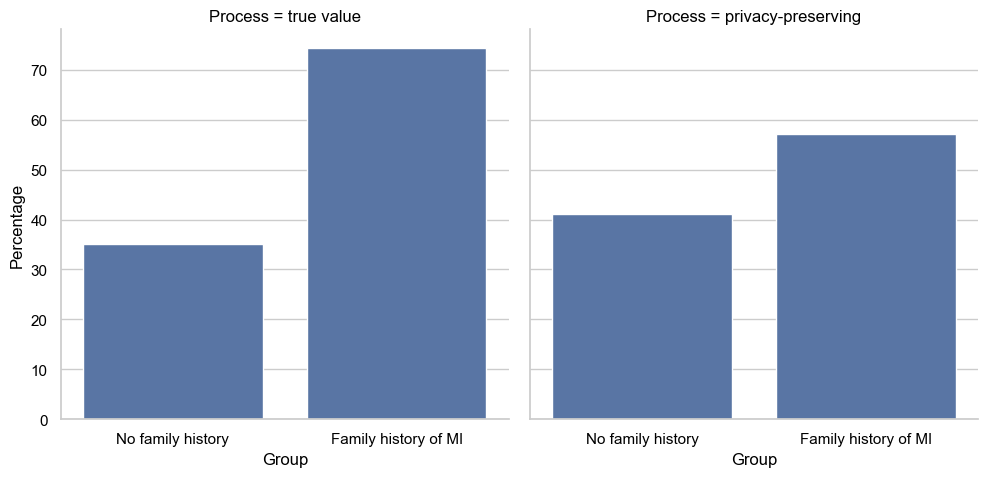

In [9]:
sns.catplot(x="Group", y="Percentage", col="Process", data=DF[DF.Variable == 'family_history'], kind="bar")

### Observation 2

participants working remotetly have the same probably of being diagnosed with mental illness as participants that do not work remotely.

In [10]:
DF[DF.Variable == 'remote_work'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,Percentage
0,Does not work remotely,true value,424,429,remote_work,49.706917
2,Does not work remotely,privacy-preserving,373,348,remote_work,51.733703
1,Works remotely,true value,191,169,remote_work,53.055556
3,Works remotely,privacy-preserving,210,176,remote_work,54.404145


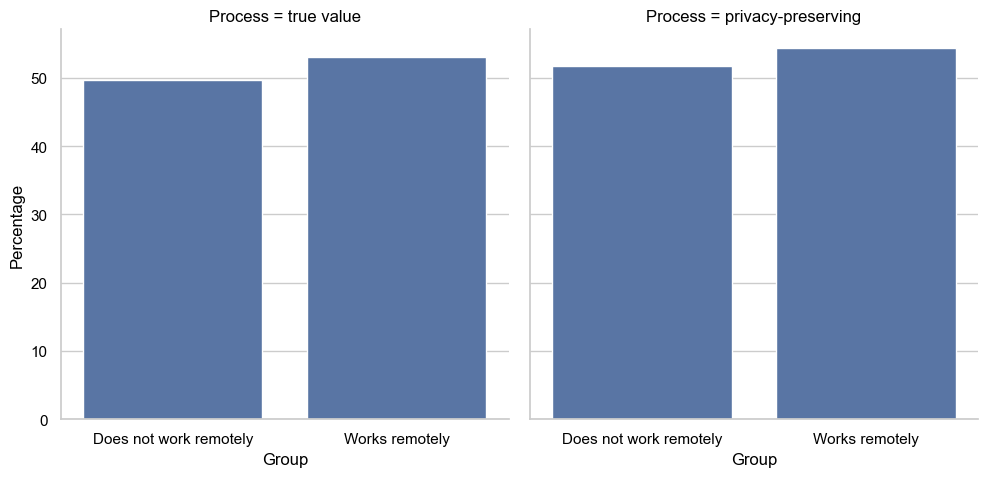

In [11]:
sns.catplot(x="Group", y="Percentage", col="Process", data=DF[DF.Variable == 'remote_work'], kind="bar")

# Privacy by design

An adversarial researcher might try to drill down the data in order to get information about specific survey participants.

Differential privacy mechanisms are designed to address such queries with suficient noise to mask the participation of any individual.

In scenarios without a trusted curator, the SmartNoise library provides accuracy intervals to the researcher. An $\alpha$-level accuracy guarantee a promise that (with probability $1-\alpha$)

$$
M(D) \in [M_{DP}(D)-a, M_{DP}(D)+a]
$$

where $M(D)$ is the query response of function $M$ on database $D$ without differential privacy, and $M_{DP}(D)$ is the response with differential privacy.

Accuracy pitfalls and edge cases are discussed in [this notebook](https://github.com/opendifferentialprivacy/smartnoise-samples/tree/master/analysis/accuracy_pitfalls.ipynb)

## Observation 3

The US has the biggest percent of professionals in the tech industry diagnosed with mental illness (around 54%). In other countries having the lowest percentages, fewer than 40% of tech workers have been treated for mental illness.

In [12]:
DF[DF.Variable == 'country'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,Percentage
3,CA,true value,34,32,country,51.515152
7,CA,privacy-preserving,41,0,country,100.000000
0,Other,true value,93,147,country,38.750000
4,Other,privacy-preserving,127,143,country,47.037037
2,UK,true value,88,87,country,50.285714
6,UK,privacy-preserving,132,115,country,53.441296
1,US,true value,400,332,country,54.644809
5,US,privacy-preserving,486,322,country,60.148515


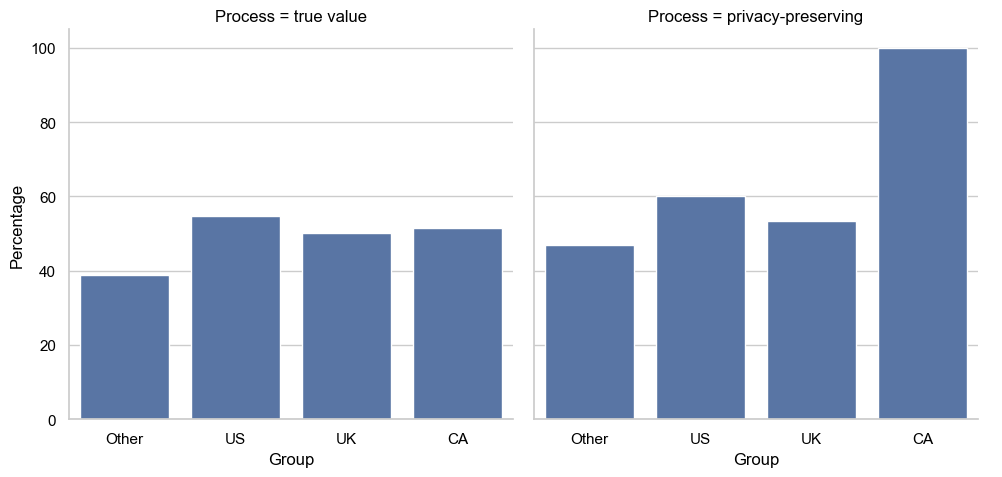

In [13]:
sns.catplot(x="Group", y="Percentage", col="Process", data=DF[DF.Variable == 'country'], kind="bar")

## Observation 4

As we explore the percentage of participants in each age group that sought MI treatment, we observe that very similar conclusions can be drawn from true values and from privacy preserving values. The exception in for age group of participants 60+ years old. 

As expected, in very small data partitions the distortions are greater.


In [14]:
DF[DF.Variable == 'age'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,Percentage
0,21-30,true value,225,253,age,47.071130
5,21-30,privacy-preserving,222,211,age,51.270208
1,31-40,true value,285,269,age,51.444043
6,31-40,privacy-preserving,218,245,age,47.084233
2,41-50,true value,87,62,age,58.389262
7,41-50,privacy-preserving,47,115,age,29.012346
3,50-60,true value,15,11,age,57.692308
8,50-60,privacy-preserving,0,0,age,NaN
4,60+,true value,3,3,age,50.000000
9,60+,privacy-preserving,34,0,age,100.000000


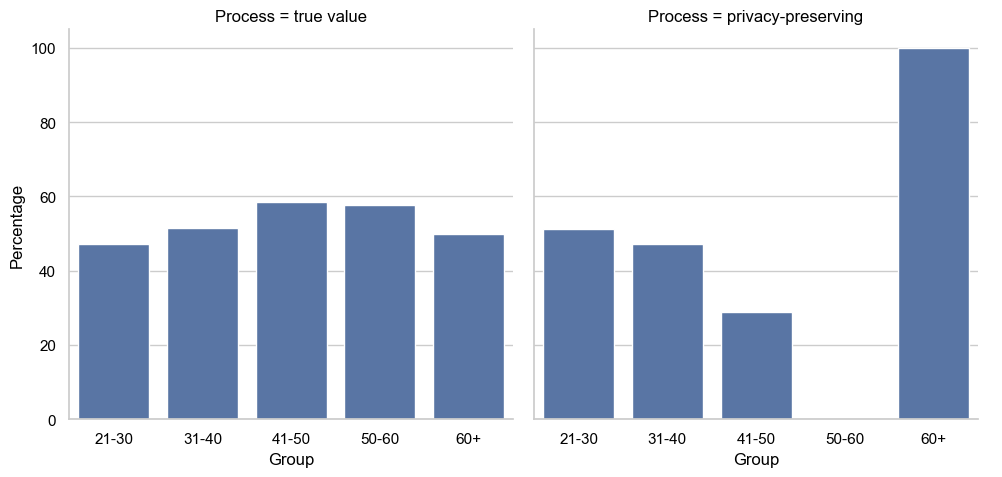

In [15]:
sns.catplot(x="Group", y="Percentage", col="Process", data=DF[DF.Variable == 'age'], kind="bar")

# Comparing associations between variables
### Different variables and variable 'treatment for MI'

## Intercorrelation of two discrete variables

Cramér's V, sometimes referred to as Cramér's phi (denoted as φc), is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic.

φc is the intercorrelation of two discrete variables. and may be used with variables having two or more levels. φc is a symmetrical measure, it does not matter which variable we place in the columns and which in the rows. Also, the order of rows/columns doesn't matter, so φc may be used with nominal data types or higher (notably ordered or numerical).

Source: Wikipedia

In [16]:
def cramers_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = sum(confusion_matrix.sum())
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [28]:
Coefs_var = ['Family history', 'Gender', 'Remote work', 'Age', 'Country'] 
coefs, dpcoefs = [], []
for variable in ['family_history', 'gender', 'remote_work', 'age', 'country']: 
    try: 
        c = cramers_stat(DF[(DF.Variable == variable)&(DF.Process == 'true value')][['Participants on treatment MI ', 'Participants not on treatment MI']])
    except: 
        c = 0
    try: 
        dpc = cramers_stat(DF[(DF.Variable == variable)&(DF.Process == 'privacy-preserving')][['Participants on treatment MI ', 'Participants not on treatment MI']])
    except: 
        dpc = 0
    coefs.append(c)
    dpcoefs.append(dpc)

c = {'True Coef': coefs,
        'Privacy Coef':dpcoefs}
cramer_coef = pd.DataFrame(data=c, index = Coefs_var)
cramer_coef

,True Coef,Privacy Coef
Family history,0.380581,0.155613
Gender,0.196000,0.336305
Remote work,0.002006,0.000000
Age,0.046954,0.000000
Country,0.112341,0.178295
